In [ ]:
# RNN for time-series prediction
# source: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [15]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

# fix random seed for reproducibility
numpy.random.seed(7)

# configure plotting
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

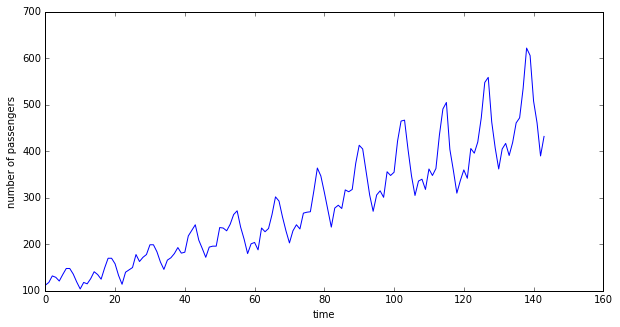

In [17]:
# load the dataset
dataframe = pandas.read_csv('./data/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
plt.plot(dataset)
plt.xlabel('time')
plt.ylabel('number of passengers')
plt.show()

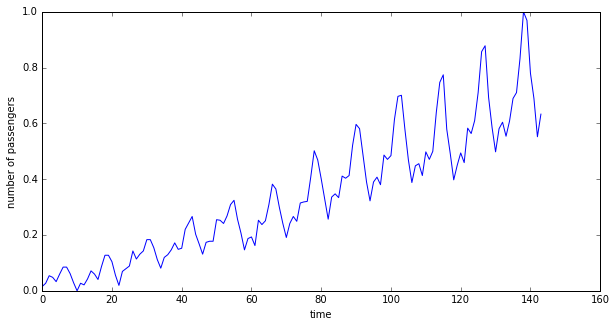

In [18]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
plt.plot(dataset)
plt.xlabel('time')
plt.ylabel('number of passengers')
plt.show()

(96, 48)


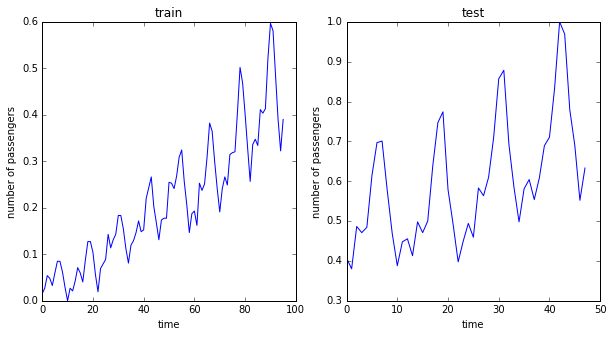

In [20]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
plt.subplot(121)
plt.plot(train)
plt.title('train')
plt.xlabel('time')
plt.ylabel('number of passengers')
plt.subplot(122)
plt.plot(test)
plt.title('test')
plt.xlabel('time')
plt.ylabel('number of passengers')
plt.show()

In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

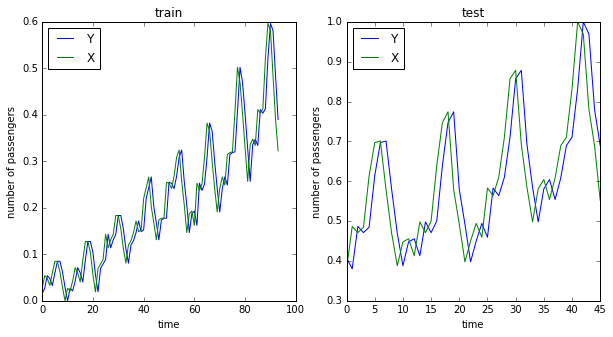

In [27]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
plt.subplot(121)
plt.plot(trainX)
plt.plot(trainY)
plt.title('train')
plt.xlabel('time')
plt.ylabel('number of passengers')
plt.legend(('Y','X'), loc = 'upper left')

plt.subplot(122)
plt.plot(testX)
plt.plot(testY)
plt.title('test')
plt.xlabel('time')
plt.ylabel('number of passengers')
plt.legend(('Y','X'), loc = 'upper left')
plt.show()

In [28]:
# reshape input to be [samples, time steps, features]
print 'initial shape'
print 'trainX: ', trainX.shape
print 'testX: ', testX.shape
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print 'reshaped'
print 'trainX: ', trainX.shape
print 'testX: ', testX.shape

initial shape
trainX:  (94, 1)
testX:  (46, 1)
reshaped
trainX:  (94, 1, 1)
testX:  (46, 1, 1)


In [8]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 4)             96          lstm_input_1[0][0]               
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 1)             5           lstm_1[0][0]                     
Total params: 101
____________________________________________________________________________________________________


In [12]:
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=1)

Epoch 1/100
94/94 [==============================] - 0s - loss: 0.0070     
Epoch 2/100
94/94 [==============================] - 0s - loss: 0.0058     
Epoch 3/100
94/94 [==============================] - 0s - loss: 0.0047     
Epoch 4/100
94/94 [==============================] - 0s - loss: 0.0038     
Epoch 5/100
94/94 [==============================] - 0s - loss: 0.0031     
Epoch 6/100
94/94 [==============================] - 0s - loss: 0.0027     
Epoch 7/100
94/94 [==============================] - 0s - loss: 0.0023     
Epoch 8/100
94/94 [==============================] - 0s - loss: 0.0023     
Epoch 9/100
94/94 [==============================] - 0s - loss: 0.0022     
Epoch 10/100
94/94 [==============================] - 0s - loss: 0.0021     
Epoch 11/100
94/94 [==============================] - 0s - loss: 0.0021     
Epoch 12/100
94/94 [==============================] - 0s - loss: 0.0021     
Epoch 13/100
94/94 [==============================] - 0s - loss: 0.0021     
Epoch 14

In [13]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(numpy.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(numpy.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 126.91 RMSE
Test Score: 154.00 RMSE


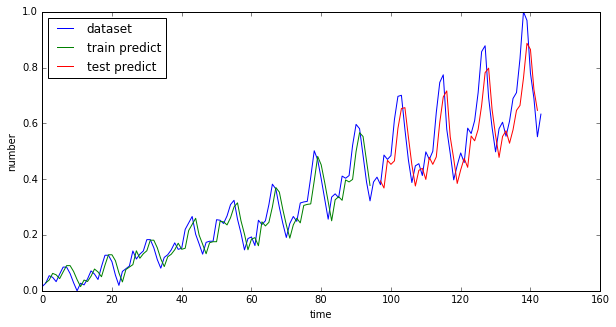

In [31]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(('dataset','train predict','test predict'), loc = 'upper left')
plt.xlabel('time')
plt.ylabel('number')
plt.show()